# Project: Web Traffic Forecasting


In [34]:
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from edward.models import Normal, Laplace, Empirical
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (24, 12)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
from model import *

## Data

History: 741, Future: 62


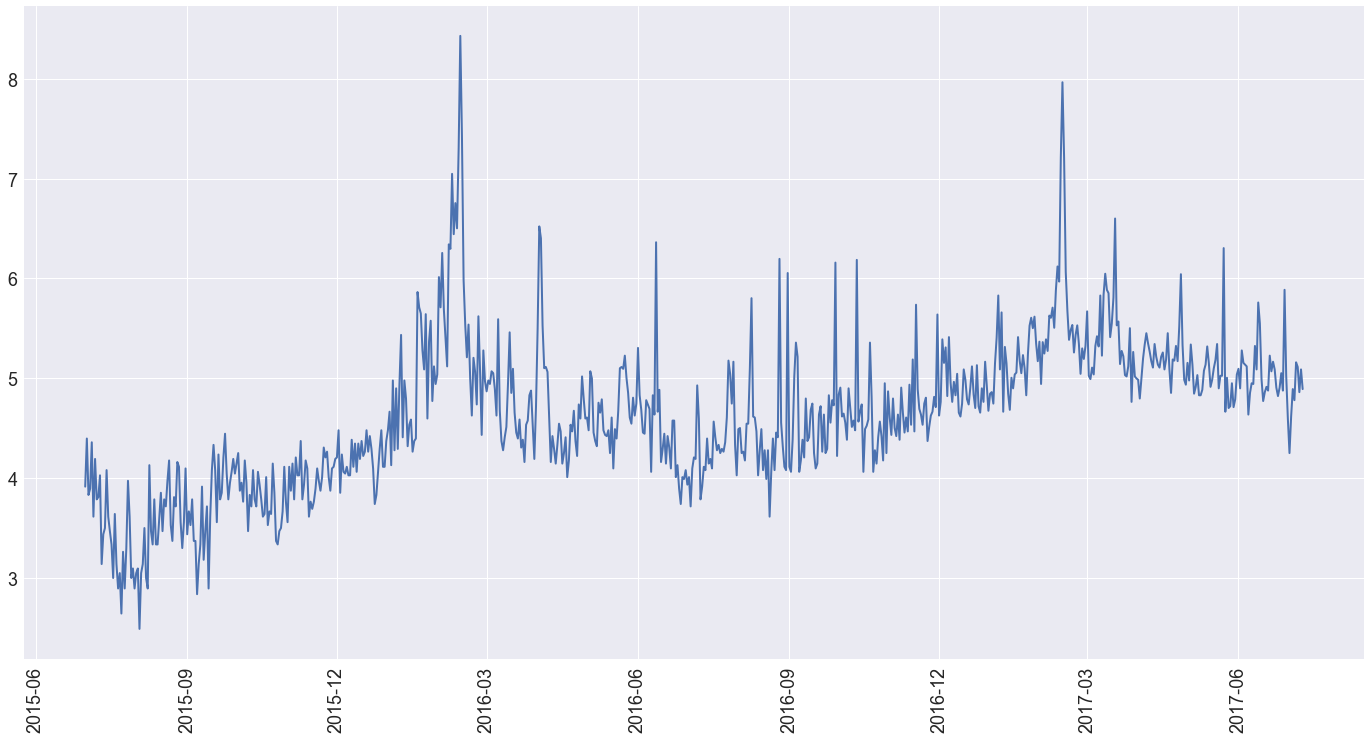

History dataframe: 741
           ds         y  views         t  y_scaled
0 2015-07-01  3.912023   50.0  0.000000  0.463886
1 2015-07-02  4.394449   81.0  0.001351  0.521092
2 2015-07-03  3.828641   46.0  0.002703  0.453998
3 2015-07-04  3.891820   49.0  0.004054  0.461490
4 2015-07-05  4.356709   78.0  0.005405  0.516616


In [35]:
# Parameters
FPATH = "./data/Valentine's_Day_en.wikipedia.org_all-access_spider.csv"
SDATE = pd.datetime(2017, 7, 10)

# Prepare dataframe
df = pd.read_csv(FPATH)
df["views"] = df["y"]
df["y"] = np.log(df["y"])
df  = setup_dataframe(df)

# Split data into train and test
history = df[df['ds'] <= SDATE].copy()
future = df[df['ds'] > SDATE].copy()
print("History: %d, Future: %d" % (history.shape[0], future.shape[0]))

plt.plot(history['ds'],history['y'])
plt.xticks(rotation=90)
plt.show()

# Add a scaled t (time index) and y (#views)
t_start = history['ds'].min()
t_scale = history['ds'].max() - t_start
if t_scale == 0:
    raise ValueError("Timeseries start == end")
y_scale = history['y'].max()
if y_scale == 0:
    y_scale = 1
history['t'] = (history['ds'] - t_start) / t_scale
history['y_scaled'] = history['y'] / y_scale
print("History dataframe: %d\n" % history.shape[0], history.head())

In [36]:
# Extract features
holiday_en_us = ['2015-01-01', '2015-01-19', '2015-05-25', '2015-07-03', '2015-09-07', '2015-11-26', '2015-11-27', '2015-12-25', 
                 '2016-01-01', '2016-01-18', '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-26', 
                 '2017-01-01', '2017-01-02', '2017-01-16', '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-10', '2017-11-23', 
                 '2017-12-25',
                 '2015-02-14', '2016-02-14', '2017-02-14']
holidays = pd.DataFrame({
  'holiday': 'US public holiday',
  'ds': pd.to_datetime(holiday_en_us),
  'lower_window': -1,
  'upper_window': 0,
  'prior_scale': 50.0
})
# holidays = None

seasonal_features, prior_scales = make_seasonality_features(history, yearly=True, weekly=True, 
                                                            holidays=holidays)
print("Seasonal features:\n")
print(seasonal_features.columns)
    
K = seasonal_features.shape[1] # number of seasonal factors
changepoints_t = get_changepoints(history, n_changepoints=25)
S = len(changepoints_t) # number of change points
changepoint_prior_scale = 0.05

print("Seasonal_features: %d\n" % K)

if holidays is not None:
    print("Holidays:\n")
    holiday_ds = []
    for feature in seasonal_features:
        if feature.split("_delim_")[0] in set(holidays['holiday']):
            holiday_ds.extend(seasonal_features[seasonal_features[feature]==1.0].index)
    print(history.iloc[np.unique(holiday_ds)]["ds"])


print("Changepoints: %d" % S)
X_train = {
    't': history['t'].as_matrix(), # day
    'A': get_changepoint_matrix(history, changepoints_t), # split indicator
    'X': seasonal_features, # seasonal vectors
    'sigmas': prior_scales, # scale on seasonality prior
}

Y_train = history['y_scaled'].as_matrix()

Seasonal features:

Index(['yearly_delim_1', 'yearly_delim_2', 'yearly_delim_3', 'yearly_delim_4',
       'yearly_delim_5', 'yearly_delim_6', 'yearly_delim_7', 'yearly_delim_8',
       'yearly_delim_9', 'yearly_delim_10', 'yearly_delim_11',
       'yearly_delim_12', 'yearly_delim_13', 'yearly_delim_14',
       'yearly_delim_15', 'yearly_delim_16', 'yearly_delim_17',
       'yearly_delim_18', 'yearly_delim_19', 'yearly_delim_20',
       'weekly_delim_1', 'weekly_delim_2', 'weekly_delim_3', 'weekly_delim_4',
       'weekly_delim_5', 'weekly_delim_6', 'US public holiday_delim_+0',
       'US public holiday_delim_-1'],
      dtype='object')
Seasonal_features: 28

Holidays:

1     2015-07-02
2     2015-07-03
67    2015-09-06
68    2015-09-07
147   2015-11-25
148   2015-11-26
149   2015-11-27
176   2015-12-24
177   2015-12-25
183   2015-12-31
184   2016-01-01
200   2016-01-17
201   2016-01-18
227   2016-02-13
228   2016-02-14
333   2016-05-29
334   2016-05-30
368   2016-07-03
369   2016-07-0

## Model

In [37]:
# Model
t = tf.placeholder(tf.float32, shape=None, name="t")        # time index
A = tf.placeholder(tf.float32, shape=(None, S), name="A")      # changepoint indicators
t_change = tf.placeholder(tf.float32, shape=(S), name="t_change") # changepoints_t
X = tf.placeholder(tf.float32, shape=(None, K), name="X")      # season vectors
sigmas = tf.placeholder(tf.float32, shape=(K,), name="sigmas")  # scale on seasonality prior
tau = tf.placeholder(tf.float32, shape=(), name="tau")      # scale on changepoints prior
       
k = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))           # initial slope
m = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))           # initial intercept
sigma_obs = Normal(loc=tf.zeros(1), scale=0.5*tf.ones(1))   # noise

delta = Laplace(loc=tf.zeros(S), scale=tau*tf.ones(S))      # changepoint rate adjustment
gamma = tf.multiply(-t_change, delta, name="gamma")

beta = Normal(loc=tf.zeros(K), scale=sigmas*tf.ones(K))     # seasonal

trend_loc = (k + ed.dot(A, delta)) * t + (m + ed.dot(A, gamma))
seas_loc = ed.dot(X, beta)
y = Normal(loc = trend_loc + seas_loc, scale = sigma_obs)

## Inference

In [38]:
# Inference
ITR = 5000                       # Number of samples.

# Init k, m
def init_km(df):
    i0, i1 = df['ds'].idxmin(), df['ds'].idxmax()
    T = df['t'].iloc[i1] - df['t'].iloc[i0]
    k = (df['y_scaled'].iloc[i1] - df['y_scaled'].iloc[i0]) / T
    m = df['y_scaled'].iloc[i0] -  k * df['t'].iloc[i0]
    return (k, m)

kinit, minit = init_km(history)
print("Initial slope / intercept: %f, %f" % (kinit, minit))
qk = Empirical(params=tf.Variable(kinit * tf.ones([ITR, 1])))
qm = Empirical(params=tf.Variable(minit * tf.ones([ITR, 1])))
qsigma_obs = Empirical(params=tf.Variable(tf.ones([ITR, 1])))
qbeta = Empirical(params=tf.Variable(tf.zeros([ITR, K])))
qdelta = Empirical(params=tf.Variable(tf.zeros([ITR, S])))

inference = ed.HMC({k: qk, m: qm, sigma_obs: qsigma_obs, beta: qbeta, delta:qdelta}, 
                   data={y: Y_train, 
                         t: X_train['t'],
                         A: X_train['A'], 
                         X: X_train['X'].as_matrix(), 
                         sigmas: X_train['sigmas'], 
                         t_change: changepoints_t,
                         tau: changepoint_prior_scale})
inference.run(step_size=5e-4)

Initial slope / intercept: 0.116009, 0.463886
5000/5000 [100%] ██████████████████████████████ Elapsed: 60s | Acceptance Rate: 0.983


## Prediction

In [39]:
# Add scaled t and y
future['t'] = (future['ds'] - t_start) / t_scale
future['y_scaled'] = future['y'] / y_scale
print("Future dataframe: %d\n" % future.shape[0], future.head())
print()

# Extract seasonality features
future_seasonal, future_prior_scales = make_seasonality_features(future, 
                                                                 yearly=True, weekly=True,
                                                                 holidays=holidays)
assert(future_seasonal.shape[1] == K)
assert(all(future_seasonal.columns == seasonal_features.columns))

X_test = {
    't': future['t'].as_matrix(), # day
    'A': get_changepoint_matrix(future, changepoints_t), # split indicator
    'X': future_seasonal, # seasonal vectors
    'sigmas': future_prior_scales, # scale on seasonality prior
}

Y_test = future['y_scaled'].as_matrix()

# Prediction
y_post = ed.copy(y, {k: qk, m: qm, sigma_obs: qsigma_obs, beta: qbeta, delta:qdelta})
sess = ed.get_session()
y_pred = np.array([sess.run([y_post], 
                  feed_dict={t: X_test['t'],
                             A: X_test['A'], 
                             X: X_test['X'].as_matrix(), 
                             sigmas: X_test['sigmas'], 
                             t_change: changepoints_t,
                             tau: changepoint_prior_scale}) for _ in range(500)]).mean(axis=0)[0]


Future dataframe: 62
             ds         y  views         t  y_scaled
741 2017-07-11  4.844187  127.0  1.001351  0.574421
742 2017-07-12  4.700480  110.0  1.002703  0.557381
743 2017-07-13  5.017280  151.0  1.004054  0.594947
744 2017-07-14  5.147494  172.0  1.005405  0.610387
745 2017-07-15  4.905275  135.0  1.006757  0.581665



## Evaluation on test data

Evalaute test data
MAPE = 10.926933
SMAPE = 5.926059
MSE = 0.007910


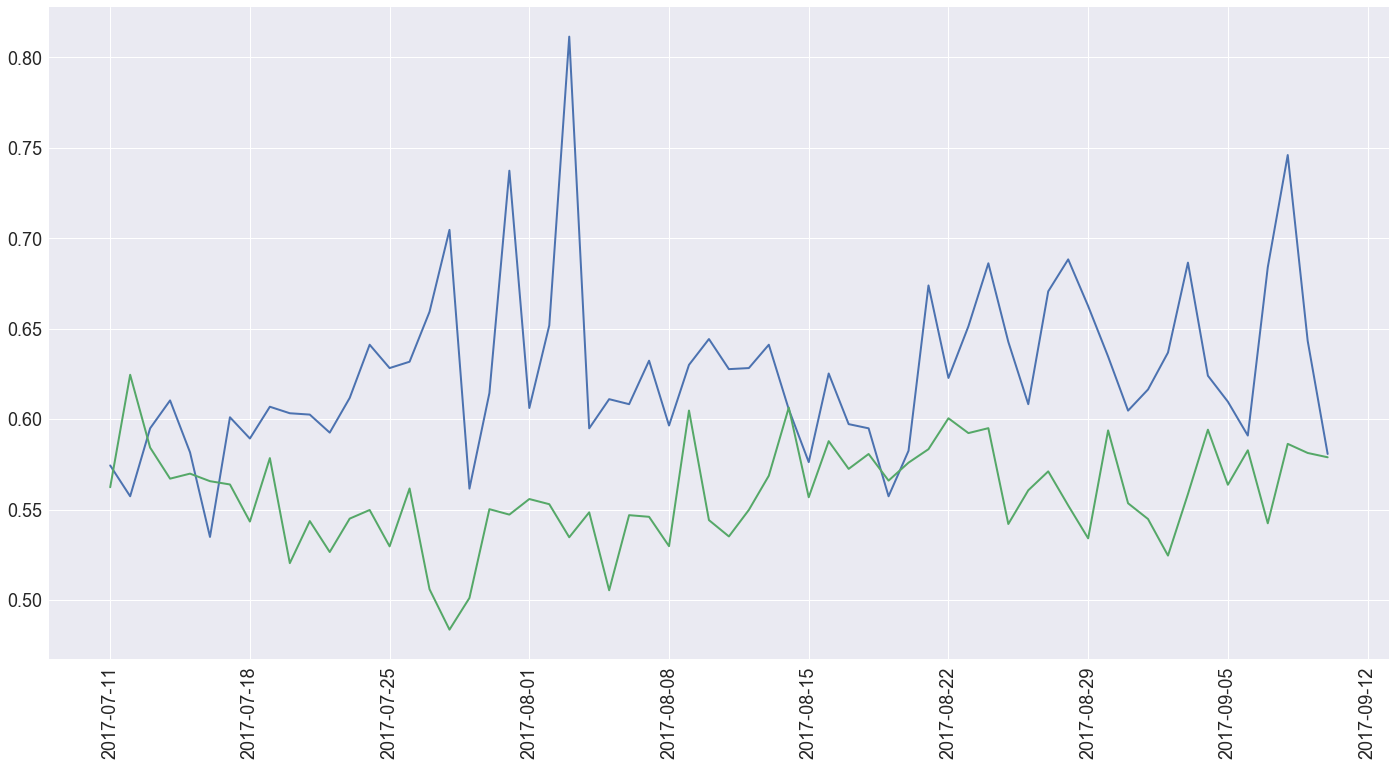

Test data before log
MAPE = 40.971608
SMAPE = 27.657460
MSE = 27451.890927


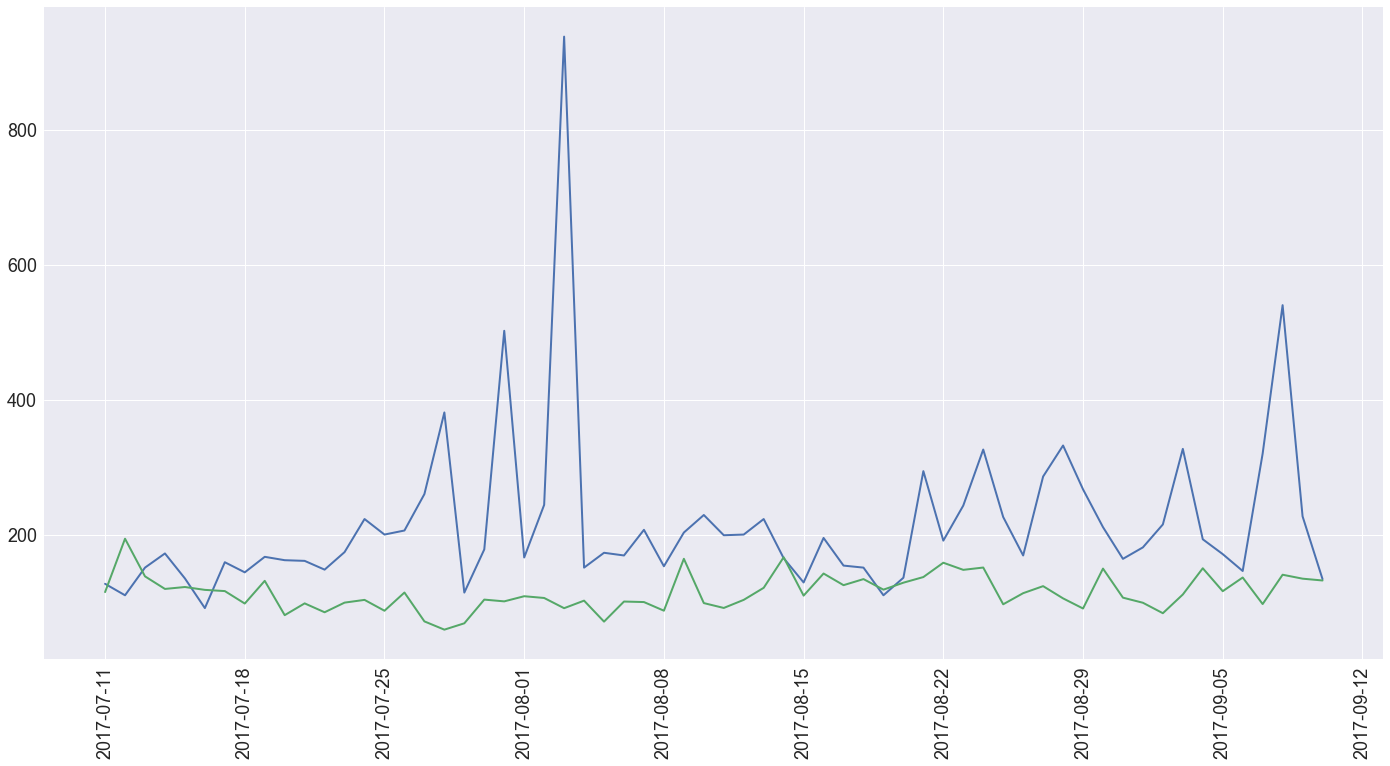

,ds,y,views,t,y_scaled
741,2017-07-11,4.844187,127.0,1.001351,0.574421
742,2017-07-12,4.700480,110.0,1.002703,0.557381
743,2017-07-13,5.017280,151.0,1.004054,0.594947
744,2017-07-14,5.147494,172.0,1.005405,0.610387
745,2017-07-15,4.905275,135.0,1.006757,0.581665


In [68]:
# Evaluate test data
# print("Mean squared error on test data:")
# print(ed.evaluate('mean_squared_error',  #mean_absolute_percentage_error
#                   data={y_post: Y_test, 
#                         t: X_test['t'],
#                         A: X_test['A'], 
#                         X: X_test['X'].as_matrix(), 
#                         sigmas: X_test['sigmas'], 
#                         t_change: changepoints_t,
#                         tau: changepoint_prior_scale}))

# Metrics 
def evalute(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean(np.abs((y_true - y_pred)) / (np.abs((y_true + y_pred)))) * 100
    mse = ((y_true - y_pred) ** 2).mean()
    print("MAPE = %f" % mape)
    print("SMAPE = %f" % smape)
    print("MSE = %f" % mse)
    
def plot_evaluate(ds, y_true, y_pred):
    plt.plot(ds, y_true)
    plt.plot(ds, y_pred)
    plt.xticks(rotation=90)
    
def plot_APE(ds, y_true, y_pred,pltname):
    ae = np.abs((y_true - y_pred)) * 100
    ptws = ae /(np.sum(ae))
    cum = np.cumsum(ptws)
    
    print(ae[:10])
    print(np.sum(ae))
    print(ptws[:10])
    
    ax1 = plt.subplot(311)
    plt.plot(ds,y_true)
    plt.plot(ds,y_pred)    
    plt.setp(ax1.get_xticklabels())
    
    ax2 = plt.subplot(312)
    plt.plot(ds,ptws)
    
    ax3 = plt.subplot(313, sharex=ax1)
    plt.plot(ds,cum)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    
    ax1.set_ylabel(pltname, labelpad=20)
    ax2.set_ylabel('pointwise absolute error', labelpad=20)
    ax3.set_ylabel('cumulative absolute error', labelpad=20)

    plt.xticks(rotation=90)   

    
print("Evalaute test data") 
evalute(future['y_scaled'], y_pred)
plot_evaluate(future['ds'],future['y_scaled'],y_pred)
plt.show()

print("Test data before log") 
evalute(future['views'],np.exp(y_pred * y_scale))
plot_evaluate(future['ds'],future['views'],np.exp(y_pred * y_scale))
plt.show()
future.head()

# plot_APE(future['ds'],future['y_scaled'],y_pred,'y_scaled')
# plt.show()



## Evaluation on train data

0    1.651270
1    4.230015
2    4.318836
3    1.449610
4    7.677575
5    3.847558
6    3.923832
7    4.672870
8    2.315257
9    2.087063
Name: y_scaled, dtype: float64
2846.78598461
0    0.000580
1    0.001486
2    0.001517
3    0.000509
4    0.002697
5    0.001352
6    0.001378
7    0.001641
8    0.000813
9    0.000733
Name: y_scaled, dtype: float64
  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  axes: an :class:`~matplotlib.axes.Axes` instance 
  backgroundcolor: any matplotlib color 
  bbox: FancyBboxPatch prop dict 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color: any matplotlib color 
  contains: a callable function 
  family or fontfamily or fontname or name: [FONTNAME | 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace' ] 
  fig

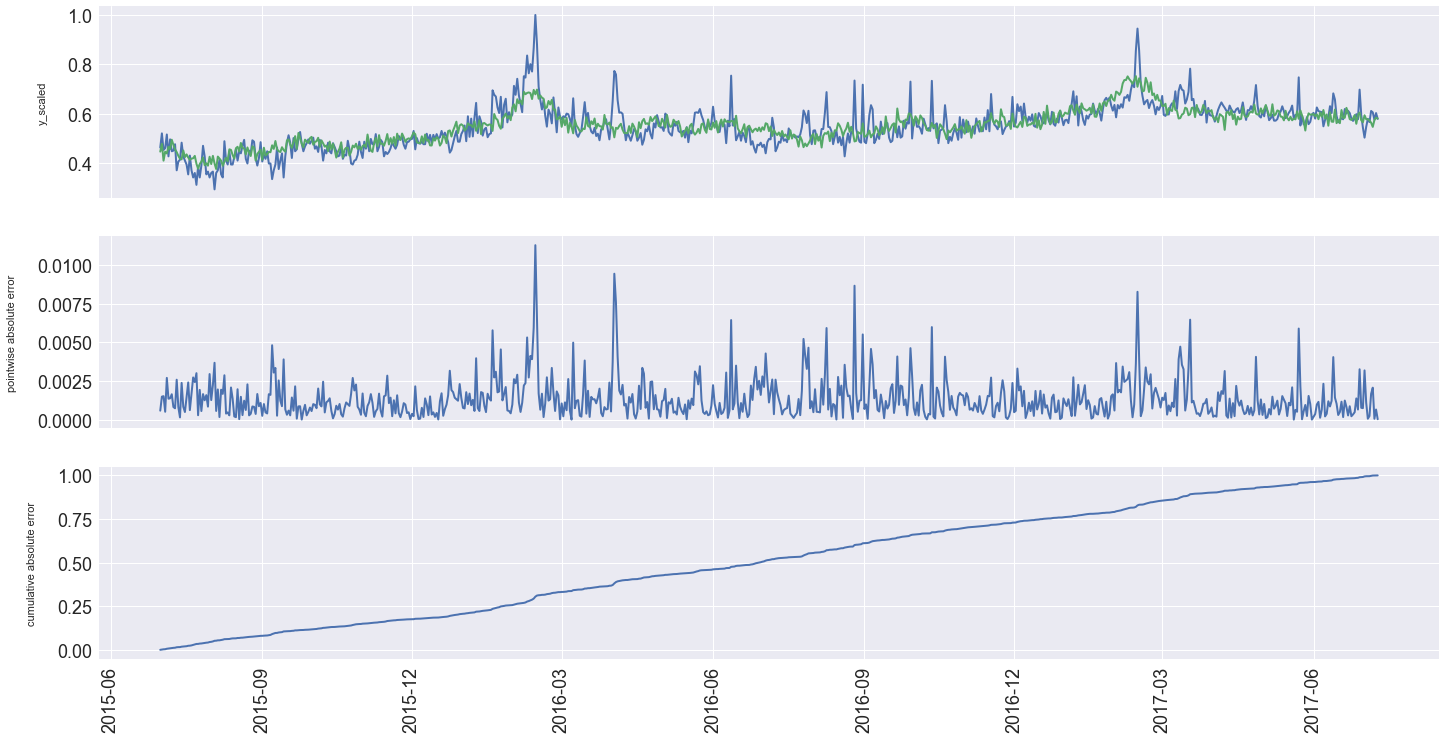

In [62]:
# Training error 
y_train_pred = np.array([sess.run([y_post], 
                  feed_dict={t: X_train['t'],
                             A: X_train['A'], 
                             X: X_train['X'].as_matrix(), 
                             sigmas: X_train['sigmas'], 
                             t_change: changepoints_t,
                             tau: changepoint_prior_scale}) for _ in range(500)]).mean(axis=0)[0]


print("Evalaute train data") 
evalute(history['y_scaled'], y_train_pred)
plot_evaluate(history['ds'], history['y_scaled'],y_train_pred)
plot_evaluate(future['ds'],future['y_scaled'],y_pred)
plt.show()

print("train data before log") 
evalute(history['views'],np.exp(y_train_pred * y_scale))
plot_evaluate(history['ds'], history['views'],np.exp(y_train_pred * y_scale))
plot_evaluate(future['ds'],future['views'],np.exp(y_pred * y_scale))
plt.show()

# plot_APE(history['ds'], history['y_scaled'],y_train_pred, 'y_scaled')
# plt.show()

## Posterior Check & PPC

Inferred posterior k: mean = 0.155482, stddev = 0.027385
Inferred posterior m: mean = 0.475138, stddev = 0.016488
Inferred posterior noise: mean = 0.202517, stddev = 0.286690


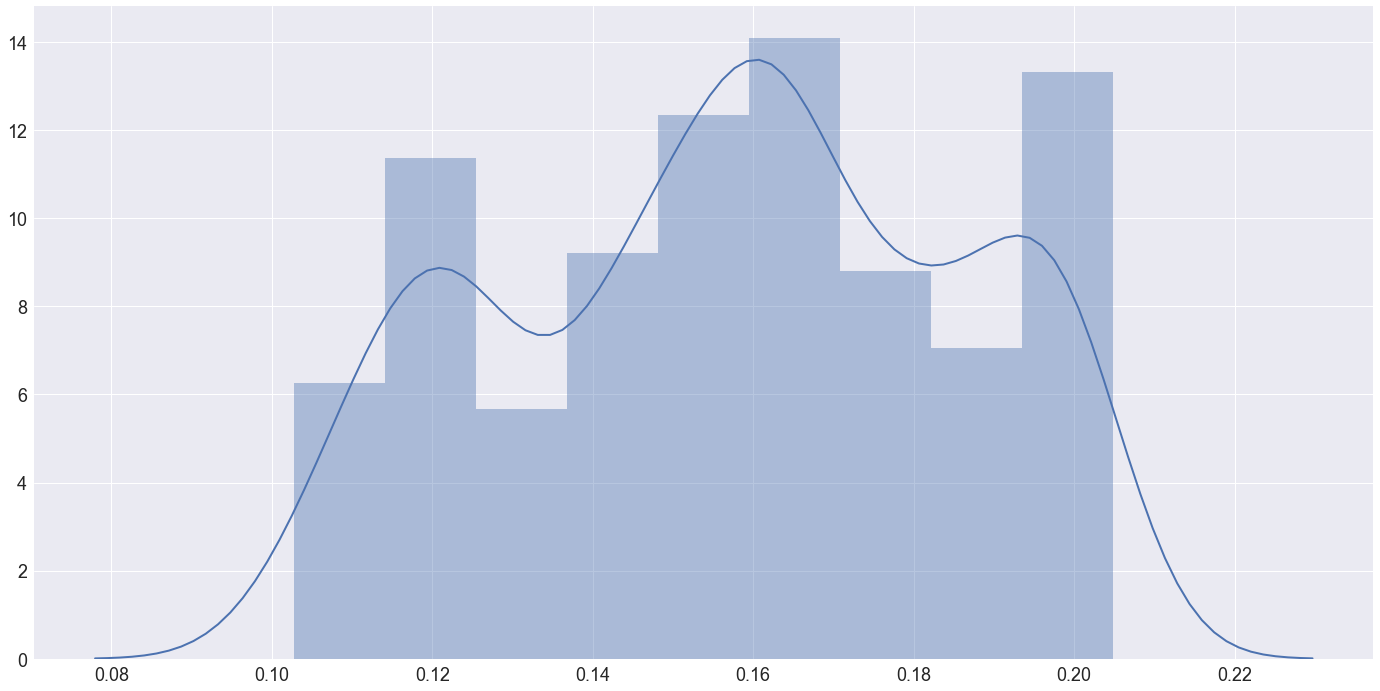

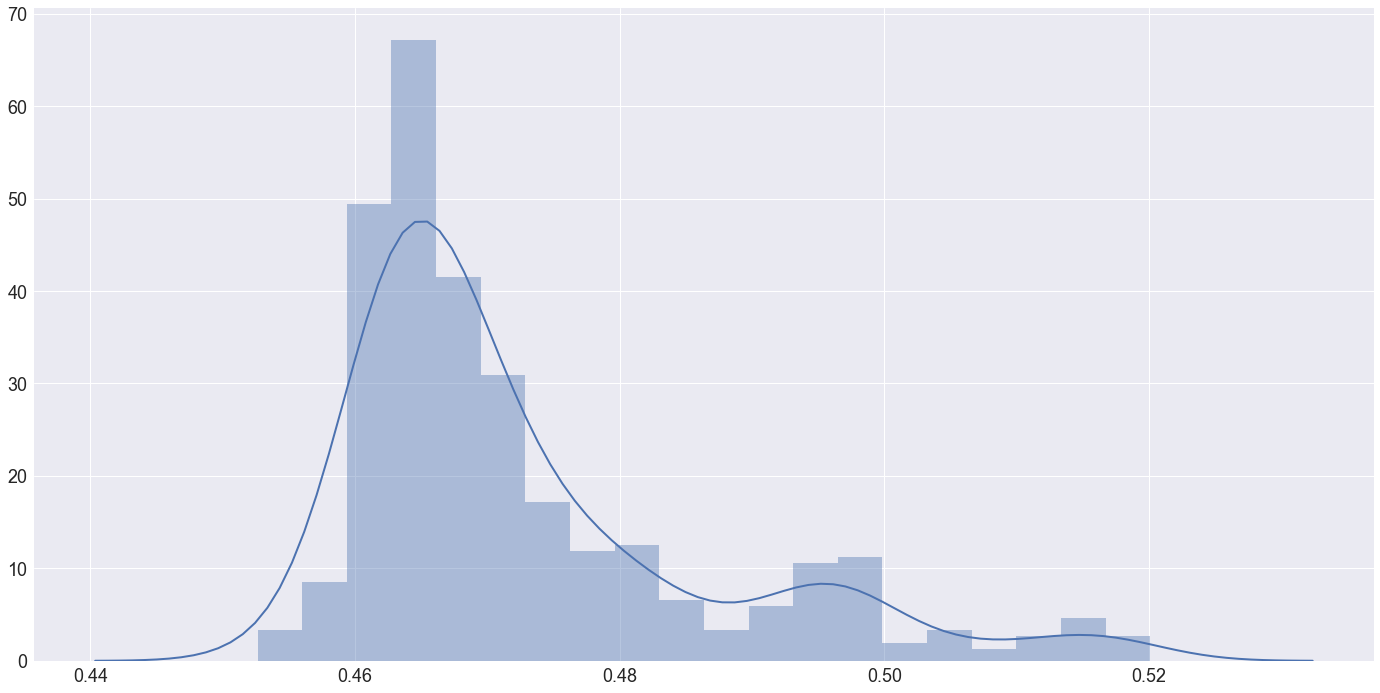

In [64]:
# Posterior check
kmean, kstddev = sess.run([qk.mean(), qk.stddev()])
print("Inferred posterior k: mean = %f, stddev = %f" % (kmean, kstddev))
mmean, mstddev = sess.run([qm.mean(), qm.stddev()])
print("Inferred posterior m: mean = %f, stddev = %f" % (mmean, mstddev))

noise_mean, noise_stddev = sess.run([qsigma_obs.mean(), qsigma_obs.stddev()])
print("Inferred posterior noise: mean = %f, stddev = %f" % (noise_mean, noise_stddev))

nburn = 500
stride = 10
sns.distplot(qk.params.eval()[nburn:ITR:stride])
plt.show()
sns.distplot(qm.params.eval()[nburn:ITR:stride])
plt.show()

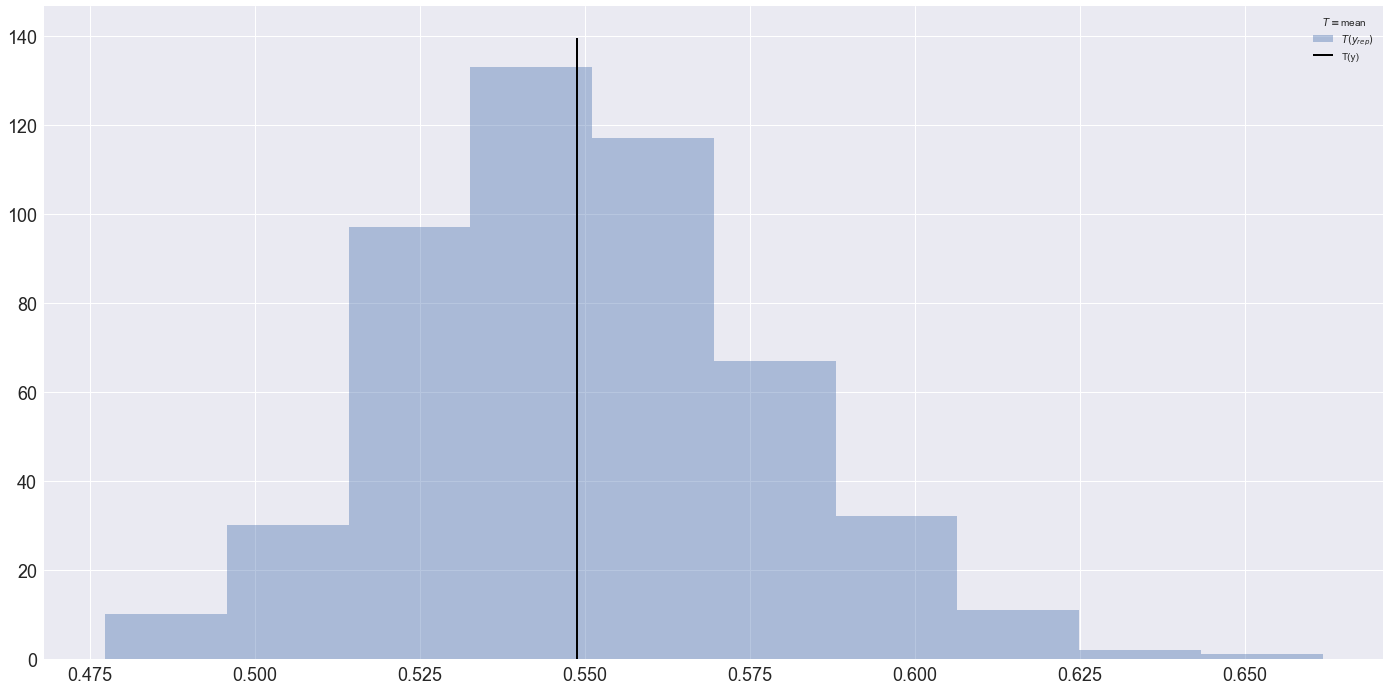

In [67]:
import seaborn as sns
sns.__version__

# test data
y_post = ed.copy(y, {k: qk, m: qm, sigma_obs: qsigma_obs, beta: qbeta, delta:qdelta})
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_mean(xs[y_post]), 
       data={y_post: Y_train, 
            t: X_train['t'],
            A: X_train['A'], 
            X: X_train['X'].as_matrix(), 
            sigmas: X_train['sigmas'], 
            t_change: changepoints_t,
            tau: changepoint_prior_scale},n_samples=500)               
ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

## Visualize 

In [ ]:
# # Prediction
# sess = ed.get_session()

# # TODO: mean?
# y_pred = sess.run([y_post.mean()], 
#                   feed_dict={t: X_test['t'],
#                              A: X_test['A'], 
#                              X: X_test['X'].as_matrix(), 
#                              sigmas: X_test['sigmas'], 
#                              t_change: changepoints_t,
#                              tau: changepoint_prior_scale})[0]
# plt.plot(future['ds'], future['y_scaled'])
# plt.plot(future['ds'], y_pred)
# plt.show()

# # Trend = k + ed.dot(A, delta)) * t + (m + ed.dot(A, gamma)
# trend_post = ed.copy(trend_loc, {k: qk, m: qm, delta:qdelta})
# seas_post = ed.copy(seas_loc, {beta: qbeta})
# trend_pred, seas_pred = sess.run([trend_post, seas_post], 
#                                  feed_dict={t: X_test['t'],
#                              A: X_test['A'], 
#                              X: X_test['X'].as_matrix(), 
#                              sigmas: X_test['sigmas'], 
#                              t_change: changepoints_t,
#                              tau: changepoint_prior_scale})

# # Plot trend
# plt.plot(future['ds'], future['y_scaled'])
# plt.plot(future['ds'], trend_pred)
# plt.show()

# # Plot seasonal
# plt.plot(future['ds'], future['y_scaled'])
# plt.plot(future['ds'], seas_pred)
# plt.show()

# # Plot trend + seasonal (no noise)
# plt.plot(future['ds'], future['y_scaled'])
# plt.plot(future['ds'], trend_pred + seas_pred) # no noise
# plt.show()

# def smape(y_true, y_pred):
#     denominator = (np.abs(y_true) + np.abs(y_pred))
#     diff = np.abs(y_true - y_pred) / denominator
#     diff[denominator == 0] = 0.0
#     return 200 * np.mean(diff)

# # Metrics 
# mape = np.mean(np.abs((future['y_scaled'] - y_pred) / future['y_scaled'])) * 100
# mse = ((future['y_scaled'] - y_pred) ** 2).mean()
# #mse = tf.reduce_mean(tf.square(y_pred - future['y_scaled']))
# print("MAPE = %f" % mape)
# print("SMAPE = %f" % mape)
# print("MSE = %f" % mse)

## Visualize

In [ ]:
# def visualise(X_data, y_data, k, m, sigma_obs, beta, delta, n_samples=10):
#     k = k.sample(n_samples).eval()
#     m = m.sample(n_samples).eval()
#     sigma_obs = sigma_obs.sample(n_samples).eval()
# #     beta = beta.sample(n_samples).eval()
# #     delta = delta.sample(n_samples).eval()
#     plt.scatter(X_data.iloc[:, 0], y_data)
#     inputs = np.linspace(-1, 1, num=400)
#     for ns in range(n_samples):
#         output = ???
#     plt.plot(inputs, output)
# visualise(data['X'], data['y'],k, m, sigma_obs, beta, delta)
# visualise(data['X'], data['y'],qk, qm, qsigma_obs, qbeta, qdelta)

# Facebook Prophet


In [ ]:
# from fbprophet import Prophet

# # Facebook Prophet
# df = pd.read_csv("./data/Selena_en.wikipedia.org_all-access_spider.csv")
# df["y"] = np.log(df["y"])
# df.head()
# m_pp = Prophet()
# m_pp.fit(history)

In [ ]:
# future = m_pp.make_future_dataframe(periods=60)
# future.tail()
# forecast = m_pp.predict(future)
# forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# m_pp.plot(forecast);

In [ ]:
# m_pp.plot_components(forecast);

In [ ]:
# evalute(forecast['yhat_'], y_pred)